# Melodify

## Dependencies

In [1]:
! pip install librosa numpy scikit-learn torch transformers

In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u432-ga~us1-0ubuntu2~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u432-ga~us1-0ub

## Preprocessing


In [3]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

### Metadata

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

# Step 1: Data Ingestion

# Load the datasets from the specified folder in the drive
albums_df = pd.read_csv('/content/drive/My Drive/CS483_Data/Albums.csv')
artists_df = pd.read_csv('/content/drive/My Drive/CS483_Data/Artists.csv')
users_df = pd.read_excel('/content/drive/My Drive/CS483_Data/Users.xlsx')

# Step 2: Data Preprocessing
# Data Cleaning Module
albums_df.drop_duplicates(inplace=True)
artists_df.drop_duplicates(inplace=True)
users_df.drop_duplicates(inplace=True)

# Handle missing values
albums_df.fillna(method='ffill', inplace=True)
artists_df.fillna(method='ffill', inplace=True)
users_df.fillna(method='ffill', inplace=True)

print('______ALBUM________')
print(albums_df.info())
print('______ARTIST________')
print(artists_df.info())
print('______USER________')
print(users_df.info())

<ipython-input-5-d45859d0adf0>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  albums_df.fillna(method='ffill', inplace=True)
<ipython-input-5-d45859d0adf0>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  artists_df.fillna(method='ffill', inplace=True)
<ipython-input-5-d45859d0adf0>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  users_df.fillna(method='ffill', inplace=True)


______ALBUM________
<class 'pandas.core.frame.DataFrame'>
Index: 28743 entries, 0 to 28942
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   artist          28743 non-null  object
 1   album           28743 non-null  object
 2   mbid            28743 non-null  object
 3   listeners       28743 non-null  int64 
 4   playcount       28743 non-null  int64 
 5   tracks          28743 non-null  object
 6   tags            28743 non-null  object
 7   similar_tracks  28743 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.0+ MB
None
______ARTIST________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11777 entries, 0 to 11776
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      11777 non-null  int64  
 1   Name            11777 non-null  object 
 2   MBID            11777 non-null  object 
 3   similar_artist  11777 

In [6]:
# get the unique tags from all artists and albums
unique_tags = set()
for tags in artists_df['tags']:
    val = tags.replace('[', '').replace(']', '').replace("'", '').split(', ')
    unique_tags.update(val)

for tags in albums_df['tags']:
    val = tags.replace('[', '').replace(']', '').replace("'", '').split(', ')
    unique_tags.update(val)

print(len(unique_tags))

4049


In [7]:
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import gensim.downloader as api

# Load the pre-trained Word2Vec model
try:
    model = api.load('word2vec-google-news-300')
except Exception as e:
    print(f"Error loading word2vec model: {e}")
    print("Trying to download the model...")
    model = api.load('word2vec-google-news-300')


def get_embedding(tags):
    embeddings = []
    for tag in word_tokenize(tags):
      try:
        embeddings.append(model[tag])
      except KeyError:
          # Handle words not in vocabulary (e.g., use a zero vector or a special token)
          embeddings.append(np.zeros(300)) # Or handle differently based on your needs.
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(300)


albums_df['tag_embedding'] = albums_df['tags'].apply(lambda x: get_embedding(x.replace('[', '').replace(']', '').replace("'", '')))
artists_df['tag_embedding'] = artists_df['tags'].apply(lambda x: get_embedding(x.replace('[', '').replace(']', '').replace("'", '')))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [8]:
albums_df.head()


,artist,album,mbid,listeners,playcount,tracks,tags,similar_tracks,tag_embedding
0,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Duvet,"['anime', 'serial experiments lain', 'british'...","Komm, Susser Tod (M-10 Director's Edit Version...","[0.021059672037760418, 0.032468159993489586, 0..."
1,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Twilight,"['anime', 'serial experiments lain', 'british'...","Elephant, Deeply, Brand New City, Advice, Just...","[0.021059672037760418, 0.032468159993489586, 0..."
2,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Fool,"['anime', 'serial experiments lain', 'british'...","Rain, Scoring","[0.021059672037760418, 0.032468159993489586, 0..."
3,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Rain,"['anime', 'serial experiments lain', 'british'...","Scoring, Fool","[0.021059672037760418, 0.032468159993489586, 0..."
4,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Elephant,"['anime', 'serial experiments lain', 'british'...","Rain, Fool","[0.021059672037760418, 0.032468159993489586, 0..."


In [9]:
artists_df.head()

,Unnamed: 0,Name,MBID,similar_artist,listeners,play_counts,tags,summary,top_album,Unnamed: 9,top_songs,tag_embedding
0,0,Nirvana,9282c8b4-ca0b-4c6b-b7e3-4f7762dfc4d6,"['Kurt Cobain', 'Alice in Chains', 'Soundgarde...",6297168,418658293,"['Grunge', 'rock', 'alternative', 'alternative...","There are multiple artists tracked as ""Nirvana...","Nevermind, In Utero, MTV Unplugged in New York...",NaN,"Smells Like Teen Spirit, Come as You Are, Lith...","[0.0396484375, -0.03963623046875, -0.026635742..."
1,1,The Killers,95e1ead9-4d31-4808-a7ac-32c3614c116b,"['Brandon Flowers', 'Kings of Leon', 'Snow Pat...",5950326,291647767,"['indie', 'rock', 'indie rock', 'alternative',...",There are multiple artists using this name:\n\...,"Hot Fuss, Sam's Town, Day & Age, Sawdust, Dire...",NaN,"Mr. Brightside, Somebody Told Me, When You Wer...","[0.024547230113636364, -0.06550181995738637, -..."
2,2,Radiohead,a74b1b7f-71a5-4011-9441-d0b5e4122711,"['Thom Yorke', 'Atoms for Peace', 'Jeff Buckle...",6815000,928426766,"['alternative', 'alternative rock', 'rock', 'i...",Radiohead are an English rock band formed in A...,"OK Computer, In Rainbows, Pablo Honey, The Ben...",NaN,"Creep, Karma Police, No Surprises, Paranoid An...","[0.012548828125, -0.06229248046875, -0.0531982..."
3,3,Gorillaz,e21857d5-3256-4547-afb3-4b6ded592596,"['Damon Albarn', 'The Good, the Bad & the Quee...",5617912,363054163,"['alternative', 'electronic', 'Hip-Hop', 'rock...",Gorillaz are a British virtual band created in...,"Demon Days, Gorillaz, Plastic Beach, Humanz (D...",NaN,"Feel Good Inc., Clint Eastwood, DARE, On Melan...","[0.008083767361111112, -0.05522325303819445, -..."
4,4,Coldplay,cc197bad-dc9c-440d-a5b5-d52ba2e14234,"['Keane', 'Imagine Dragons', 'Snow Patrol', 'T...",7710436,592812260,"['rock', 'alternative', 'britpop', 'alternativ...",Coldplay are a britpop band formed in London i...,"Parachutes, A Rush of Blood to the Head, Viva ...",NaN,"Yellow, Viva la Vida, The Scientist, Clocks, F...","[0.0134521484375, -0.04891357421875, -0.031713..."


In [10]:
len(albums_df), len(artists_df)

(28743, 11777)

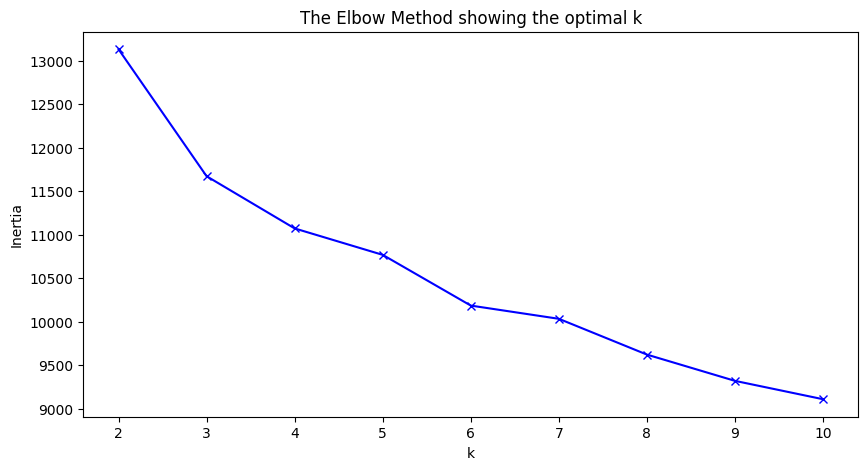

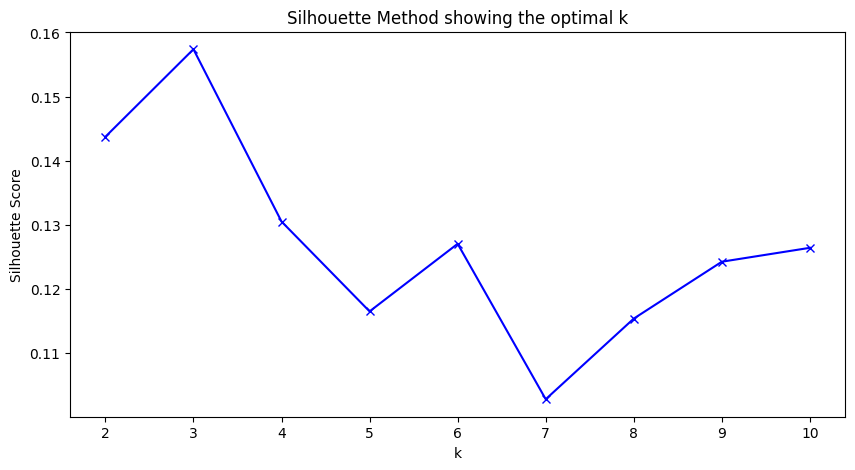

In [16]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Combine tag embeddings from albums and artists
tag_embeddings = albums_df['tag_embedding'].tolist()

# Determine optimal k using the elbow method
inertia = []
silhouette_avg = []
K = range(2, 11)  # Test k values from 2 to 10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)  # Initialize KMeans with random_state for reproducibility
    kmeans.fit(tag_embeddings)
    inertia.append(kmeans.inertia_)

    # Calculate silhouette score
    cluster_labels = kmeans.labels_
    if len(np.unique(cluster_labels)) > 1:  # Silhouette score needs at least two clusters
      silhouette_avg.append(silhouette_score(tag_embeddings, cluster_labels))
    else:
      silhouette_avg.append(0) # Or another appropriate value for a single cluster

# Plot the elbow method graph
plt.figure(figsize=(10, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#Plot the silhouette method graph
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_avg, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method showing the optimal k')
plt.show()


#Optimal k is the value where the inertia starts to decrease linearly.
#Optimal k is the k with highest silhouette score.
#You can manually select the optimal k from the plots or using other methods.

In [17]:
import numpy as np
from sklearn.cluster import KMeans

# Determine the number of clusters (you might need to experiment with this value)
num_clusters = 7  # Example: 10 clusters

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10) # n_init increased for better results
kmeans.fit(albums_df['tag_embedding'].tolist())

# Add cluster labels to the DataFrames
albums_df['cluster'] = kmeans.labels_[:len(albums_df)]

# Now you have the cluster labels in 'cluster' column of both DataFrames
albums_df.head()

,artist,album,mbid,listeners,playcount,tracks,tags,similar_tracks,tag_embedding,cluster
0,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Duvet,"['anime', 'serial experiments lain', 'british'...","Komm, Susser Tod (M-10 Director's Edit Version...","[0.021059672037760418, 0.032468159993489586, 0...",2
1,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Twilight,"['anime', 'serial experiments lain', 'british'...","Elephant, Deeply, Brand New City, Advice, Just...","[0.021059672037760418, 0.032468159993489586, 0...",2
2,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Fool,"['anime', 'serial experiments lain', 'british'...","Rain, Scoring","[0.021059672037760418, 0.032468159993489586, 0...",2
3,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Rain,"['anime', 'serial experiments lain', 'british'...","Scoring, Fool","[0.021059672037760418, 0.032468159993489586, 0...",2
4,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Elephant,"['anime', 'serial experiments lain', 'british'...","Rain, Fool","[0.021059672037760418, 0.032468159993489586, 0...",2


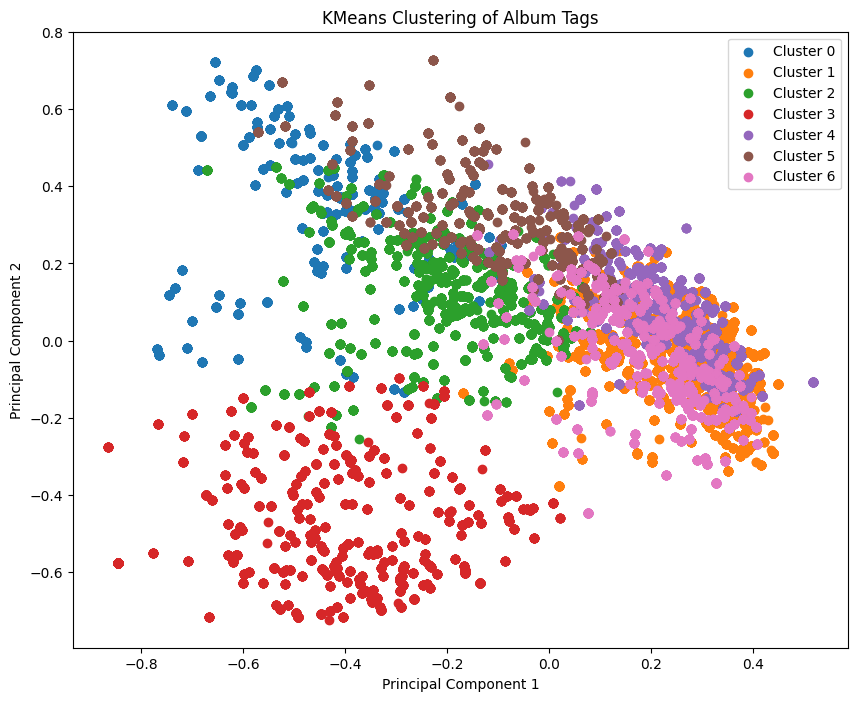

In [18]:
import matplotlib.pyplot as plt

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
pca_result = pca.fit_transform(albums_df['tag_embedding'].tolist())


# Create a scatter plot of the clusters
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    plt.scatter(pca_result[albums_df['cluster'] == i, 0], pca_result[albums_df['cluster'] == i, 1], label=f'Cluster {i}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering of Album Tags')
plt.legend()
plt.show()

In [24]:
def print_top_songs_per_cluster(albums_df, num_songs=5):
    """Prints top songs from each cluster based on playcount.

    Args:
        albums_df: DataFrame with 'cluster', 'playcount', and song title.
        num_songs: Number of top songs to print per cluster.
    """

    # Calculate the 99th percentile of playcount
    percentile_99 = albums_df['playcount'].quantile(0.99)
    print(f"99th Percentile Playcount: {percentile_99}")

    # Filter for songs in the top 1%
    top_1_percent = albums_df[albums_df['playcount'] >= percentile_99]


    for cluster_id in top_1_percent['cluster'].unique():
        cluster_songs = top_1_percent[top_1_percent['cluster'] == cluster_id]

        # Sort by playcount in descending order and take the top 'num_songs'
        top_songs = cluster_songs.sort_values(by='playcount', ascending=False).head(num_songs)

        print(f"\nTop {num_songs} songs in Cluster {cluster_id}:")
        for index, row in top_songs.iterrows():
            print(f"- {row['tracks']} (Playcount: {row['playcount']})")


print_top_songs_per_cluster(albums_df)

99th Percentile Playcount: 65759215.0

Top 5 songs in Cluster 6:
- One More Time (Playcount: 85024496)
- Something About Us (Playcount: 85024496)
- Aerodynamic (Playcount: 85024496)
- Too Long (Playcount: 85024496)
- Face to Face (Playcount: 85024496)

Top 5 songs in Cluster 1:
- Please Don't Change (feat. DJ Snake) (Playcount: 209564604)
- Somebody (Playcount: 209564604)
- Too Sad to Dance (Playcount: 209564604)
- Yes or No (Playcount: 209564604)
- Standing Next To You (Playcount: 209564604)

Top 5 songs in Cluster 5:
- Texas Reznikoff (Playcount: 76958244)
- Townie (Playcount: 76958244)
- Carry Me Out (Playcount: 76958244)
- I Will (Playcount: 76958244)
- Drunk Walk Home (Playcount: 76958244)

Top 5 songs in Cluster 2:
- Speak to Me (Playcount: 69696134)
- Breathe (In the Air) (Playcount: 69696134)
- On the Run (Playcount: 69696134)
- Time (Playcount: 69696134)
- The Great Gig in the Sky (Playcount: 69696134)

Top 5 songs in Cluster 4:
- Rolling in the Deep (Playcount: 88278026)
- Ru